In [295]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.datasets.galsim_galaxies import GalsimBlends
from case_studies.coadds.signal_noise_ratio import get_snr
from case_studies.coadds.coadd_decoder import (
    CoaddUniformGalsimPrior,
    CoaddSingleGalaxyDecoder,
    CoaddGalsimBlends,
    FullCatalogDecoder,
)
from case_studies.coadds.align_single_exposures import align_single_exposures

In [39]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [56]:
with initialize(config_path="../coadds/config"):
    cfg = compose("config", overrides=[])

In [276]:
prior = instantiate(cfg.datasets.sdss_galaxies_coadd.prior)
decoder = instantiate(cfg.datasets.sdss_galaxies_coadd.decoder)
background = instantiate(cfg.datasets.sdss_galaxies_coadd.background)

In [277]:
# check prior to get galaxy parameters
max_n_sources = 1
max_shift = 0.5
num_dithers = 400
sampled_cuggp = CoaddUniformGalsimPrior(
    prior, max_n_sources, max_shift, num_dithers
).sample(num_dithers)

In [272]:
pixel_scale = 0.393
n_sources = sampled_cuggp["n_sources"]
galaxy_params = sampled_cuggp["galaxy_params"]
locs = sampled_cuggp["locs"]
galaxy_bools = sampled_cuggp["galaxy_bools"]
star_bools = sampled_cuggp["star_bools"]
dithers = sampled_cuggp["dithers"]
offset = None

In [273]:
# check decoder to render galaxies
csgd = CoaddSingleGalaxyDecoder(
    decoder, decoder.n_bands, decoder.pixel_scale, "./data/sdss/psField-000094-1-0012-PSF-image.npy"
)
csgdgalaxy = csgd.render_galaxy(
    galaxy_params=galaxy_params[0],
    slen=decoder.slen,
    psf=decoder.psf,
    offset=offset,
    dithers=dithers,
)

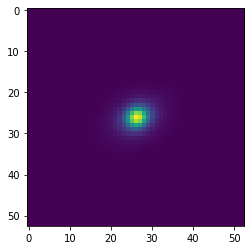

In [238]:
plt.imshow(csgdgalaxy[0].reshape(csgdgalaxy[0].shape[1], csgdgalaxy[0].shape[2]).numpy())

In [279]:
# check FullCatalogDecoder
prior = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.prior)
decoder = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog, dithers = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
    num_dithers=num_dithers,
)._sample_full_catalog()

In [240]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp, dithers)

In [280]:
image, noiseless_centered, noiseless_uncentered, image0 = decoder.render_catalog(
    full_catalog, decoder.single_decoder.psf, dithers
)

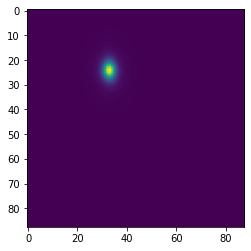

In [242]:
plt.imshow(image0[0].reshape(image0[0].shape[1], image0[0].shape[2]).numpy())

In [ ]:
# DON'T RUN FOR LARGE NUM_DITHERS
for i in range(image.shape[0]):
    plt.figure()
    plt.imshow(image[i].reshape(image[i].shape[1], image[i].shape[2]).numpy())
    plt.colorbar()

In [244]:
(
    noiseless,
    noiseless_centered,
    noiseless_uncentered,
    background,
    coadded_image,
) = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._get_images(
    full_catalog, dithers
)

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interped_images = torch.tensor(interped

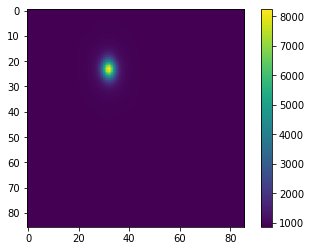

In [245]:
for i in range(coadded_image.shape[0]):
    plt.figure()
    plt.imshow(coadded_image[i].reshape(coadded_image.shape[1], coadded_image.shape[2]).numpy())
    plt.colorbar()

In [296]:
cgb = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
    num_dithers=num_dithers,
)
cgb[0]

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = rearrange(images, "d h w -> d 1 h w")
/home/wmallory/bliss/case_studies/coadds/coadd_decoder.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = 1 / (torch.tensor(aligned_images) + torch.tensor(background))


{'noiseless': tensor([[[[0.0061, 0.0063, 0.0064,  ..., 0.0205, 0.0207, 0.0209],
           [0.0066, 0.0067, 0.0069,  ..., 0.0227, 0.0229, 0.0232],
           [0.0071, 0.0072, 0.0074,  ..., 0.0252, 0.0255, 0.0257],
           ...,
           [0.0155, 0.0156, 0.0157,  ..., 0.0554, 0.0507, 0.0461],
           [0.0141, 0.0142, 0.0143,  ..., 0.0544, 0.0505, 0.0463],
           [0.0128, 0.0129, 0.0130,  ..., 0.0522, 0.0493, 0.0460]]],
 
 
         [[[0.0062, 0.0063, 0.0064,  ..., 0.0209, 0.0212, 0.0214],
           [0.0066, 0.0068, 0.0069,  ..., 0.0233, 0.0235, 0.0237],
           [0.0071, 0.0073, 0.0074,  ..., 0.0259, 0.0261, 0.0263],
           ...,
           [0.0149, 0.0150, 0.0152,  ..., 0.0587, 0.0544, 0.0499],
           [0.0136, 0.0137, 0.0138,  ..., 0.0563, 0.0532, 0.0495],
           [0.0124, 0.0125, 0.0126,  ..., 0.0528, 0.0509, 0.0482]]],
 
 
         [[[0.0061, 0.0062, 0.0063,  ..., 0.0204, 0.0206, 0.0208],
           [0.0065, 0.0066, 0.0068,  ..., 0.0226, 0.0229, 0.0231],
     